In [1]:
# Install required packages
! pip install langchain-pinecone pinecone-client sentence-transformers tqdm matplotlib tenacity


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import pandas as pd
import re
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.llms import Together
from pinecone import Pinecone, ServerlessSpec
from langchain_pinecone import PineconeVectorStore

# Constants and API keys
PINECONE_API_KEY = ""
PINECONE_INDEX_NAME = "hallucination-reduction-index"

TOGETHER_API_KEY = ""
MISTRAL_MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"

# Set API keys as environment variables
os.environ["PINECONE_API_KEY"] = PINECONE_API_KEY
os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY

In [3]:
# Load CSV
file_path = "mistral_hallucination_check.csv"
df = pd.read_csv(file_path, nrows=7000)

In [4]:
# Generate KB text file for context
with open("knowledge_base.txt", "w") as f:
    for _, row in df.iterrows():
        if pd.notnull(row["right_answer"]):
            f.write(f"Q: {row['question']}\nA: {row['right_answer']}\n\n")

In [5]:
# Load and split text
loader = TextLoader("knowledge_base.txt")
docs = loader.load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

In [6]:
# Initialize Pinecone client
pc = Pinecone(api_key=PINECONE_API_KEY)

# Check if index exists, if not create it
index_name = PINECONE_INDEX_NAME
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/var/folders/_2/n6yzr0md2fn8r03l4642zczr0000gn/T/ipykernel_14776/1692382893.py:9: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


In [7]:
if index_name not in existing_indexes:
    # Create a new index
    pc.create_index(
        name=index_name,
        dimension=384,  # The dimension for all-MiniLM-L6-v2 is 384
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )

# Get the index
index = pc.Index(index_name)

In [8]:
# Create vector store and add documents - use environment variables instead
vectorstore = PineconeVectorStore.from_documents(
    documents=chunks,
    embedding=embedding_model,
    index_name=index_name
)

In [9]:
# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Setup Together API - using the correct parameter name 'together_api_key'
llm = Together(
    model=MISTRAL_MODEL_ID,
    temperature=0.7,
    max_tokens=512
)

# Setup RAG Chain
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    return_source_documents=False
)

# Semantic similarity model
similarity_model = SentenceTransformer('all-MiniLM-L6-v2')

/var/folders/_2/n6yzr0md2fn8r03l4642zczr0000gn/T/ipykernel_14776/3609319017.py:5: LangChainDeprecationWarning: The class `Together` was deprecated in LangChain 0.0.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-together package and should be used instead. To use it run `pip install -U :class:`~langchain-together` and import as `from :class:`~langchain_together import Together``.
  llm = Together(


In [10]:
# Rate limit handling for Together API
class RateLimitError(Exception):
    """Exception raised for Together API rate limit errors."""
    pass

@retry(
    retry=retry_if_exception_type(RateLimitError),
    wait=wait_exponential(multiplier=1, min=4, max=10),
    stop=stop_after_attempt(5)
)
def run_with_retry(query):
    """Run query with retry logic for rate limits"""
    try:
        return rag_chain.run(query)
    except ValueError as e:
        if "rate_limit" in str(e):
            print(f"Rate limit hit, retrying after backoff: {str(e)}")
            # Add jitter to avoid synchronized retries
            time.sleep(random.uniform(1, 3))
            raise RateLimitError(str(e))
        raise

In [11]:
def is_hallucinated(model_answer: str, right_answer: str, threshold: float = 0.5) -> bool:
    right_embedding = similarity_model.encode(right_answer, convert_to_tensor=True)
    full_similarity = util.cos_sim(similarity_model.encode(model_answer, convert_to_tensor=True), right_embedding).item()
    max_similarity = full_similarity

    sentences = re.split(r'(?<=[.!?])\s+', model_answer)
    for sentence in sentences:
        sentence = sentence.strip()
        if not sentence:
            continue
        sentence_embedding = similarity_model.encode(sentence, convert_to_tensor=True)
        similarity = util.cos_sim(sentence_embedding, right_embedding).item()
        max_similarity = max(max_similarity, similarity)

        words = sentence.split()
        n = len(right_answer.split())
        for window_size in range(n, min(n + 3, len(words) + 1)):
            for i in range(len(words) - window_size + 1):
                chunk = " ".join(words[i:i + window_size])
                chunk_embedding = similarity_model.encode(chunk, convert_to_tensor=True)
                chunk_similarity = util.cos_sim(chunk_embedding, right_embedding).item()
                max_similarity = max(max_similarity, chunk_similarity)
                if max_similarity >= threshold:
                    break
            if max_similarity >= threshold:
                break
        if max_similarity >= threshold:
            break

    return max_similarity < threshold

In [12]:
# Apply RAG + hallucination check with batching and rate limit handling
tqdm.pandas()

# Process in smaller batches to manage rate limits
batch_size = 1000  # Adjust based on Together API limits
results = []

for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i+batch_size]
    print(f"Processing batch {i//batch_size + 1}/{(len(df) + batch_size - 1)//batch_size}")
    
    for _, row in tqdm(batch.iterrows(), total=len(batch)):
        try:
            rag_answer = run_with_retry(row["question"])
            is_hallucinated_rag = is_hallucinated(rag_answer, row["right_answer"])
            results.append({
                "question": row["question"],
                "right_answer": row["right_answer"],
                "rag_answer": rag_answer,
                "is_hallucinated_rag": is_hallucinated_rag,
                "is_hallucinated_recomputed": row["is_hallucinated_recomputed"]
            })
            # Add delay between requests to respect rate limits
            time.sleep(1)  # 1 request per second (QPS) as per error message
        except Exception as e:
            print(f"Error processing question: {row['question']}")
            print(f"Error details: {str(e)}")
            # Add the row with error information
            results.append({
                "question": row["question"],
                "right_answer": row["right_answer"],
                "rag_answer": f"ERROR: {str(e)}",
                "is_hallucinated_rag": None,
                "is_hallucinated_recomputed": row["is_hallucinated_recomputed"]
            })
    
    # Save intermediate results after each batch
    results_df = pd.DataFrame(results)
    results_df.to_csv(f"rag_results_batch_{i//batch_size + 1}.csv", index=False)
    
    # Add delay between batches
    if i + batch_size < len(df):
        print(f"Waiting between batches to respect rate limits...")
        time.sleep(5)  # 5 seconds between batches

Processing batch 1/7


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/_2/n6yzr0md2fn8r03l4642zczr0000gn/T/ipykernel_14776/2969730513.py:14: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  return rag_chain.run(query)
 96%|█████████▌| 962/1000 [49:11<14:17, 22.58s/it]  

Error processing question: What is the nickname of the host for which "Winner Take All" is best known?
Error details: Failed to connect; did you specify the correct index name?


100%|██████████| 1000/1000 [51:07<00:00,  3.07s/it]


Waiting between batches to respect rate limits...
Processing batch 2/7


100%|██████████| 1000/1000 [55:21<00:00,  3.32s/it] 


Waiting between batches to respect rate limits...
Processing batch 3/7


100%|██████████| 1000/1000 [52:43<00:00,  3.16s/it] 


Waiting between batches to respect rate limits...
Processing batch 4/7


100%|██████████| 1000/1000 [50:59<00:00,  3.06s/it] 


Waiting between batches to respect rate limits...
Processing batch 5/7


 76%|███████▌  | 756/1000 [37:19<38:31,  9.47s/it]  

Error processing question: What castle owned by Sir Ernest Wills has been a base for Menzies Clan Chief David Steuart Menzies?
Error details: Failed to connect; did you specify the correct index name?


100%|██████████| 1000/1000 [50:42<00:00,  3.04s/it]


Waiting between batches to respect rate limits...
Processing batch 6/7


  2%|▏         | 15/1000 [00:39<31:36,  1.93s/it] 

Error processing question: Nita Kumar completed her Ph.D. from the University of Chicago in History and has taught at the University of Chicago, Brown University, and the University of Michigan among other places, she presently holds the Brown Family Chair of South Asian History at which independent, coeducational and private liberal arts college with a curricular emphasis on economics, finance, international relations, government and public affairs, located in Claremont, California, United States?
Error details: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))


 95%|█████████▍| 946/1000 [1:03:23<2:45:03, 183.39s/it]

Error processing question: English National Opera commissions and premieres and The London Coliseum are both of which origin?
Error details: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))


 95%|█████████▍| 947/1000 [1:04:23<2:09:09, 146.22s/it]

Error processing question: This Indian music composer presented a 2017 Marathi film which marked the debut of which two actors?
Error details: Failed to connect; did you specify the correct index name?


100%|██████████| 1000/1000 [1:07:19<00:00,  4.04s/it]  


Waiting between batches to respect rate limits...
Processing batch 7/7


100%|██████████| 1000/1000 [48:28<00:00,  2.91s/it] 


Successful completions: 6995/7000 (99.93%)
Original hallucination rate: 28.15%
RAG hallucination rate: 11.69%


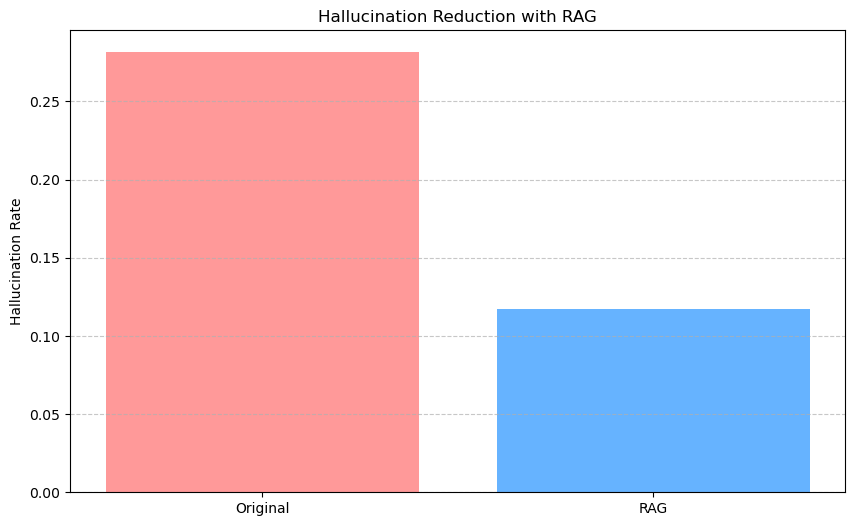

In [13]:
# Combine all results
final_df = pd.DataFrame(results)
final_df.to_csv("rag_results_complete.csv", index=False)

# Calculate hallucination rates only on successful generations
success_df = final_df[~final_df["is_hallucinated_rag"].isna()]
if len(success_df) > 0:
    original_rate = success_df["is_hallucinated_recomputed"].mean()
    rag_rate = success_df["is_hallucinated_rag"].mean()

    print(f"Successful completions: {len(success_df)}/{len(final_df)} ({len(success_df)/len(final_df):.2%})")
    print(f"Original hallucination rate: {original_rate:.2%}")
    print(f"RAG hallucination rate: {rag_rate:.2%}")

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.bar(['Original', 'RAG'], [original_rate, rag_rate], color=['#ff9999', '#66b3ff'])
    plt.ylabel('Hallucination Rate')
    plt.title('Hallucination Reduction with RAG')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('hallucination_comparison.png')
    plt.show()
else:
    print("No successful completions to analyze.")